Tools used: 
- sra-tools https://github.com/ncbi/sra-tools 
- seqtk https://github.com/lh3/seqtk
- awk https://github.com/onetrueawk/awk
- colord (original) https://github.com/refresh-bio/CoLoRd ; compiled with `MEASURE_THREADS_TIMES` defined
- pandas, seqborn, matplotlib, tqdm... 

In [1]:
import os
import time
import gzip
import shutil

import numpy as np
import subprocess as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import OrderedDict, defaultdict
from tqdm import tqdm
from pprint import pprint

from IPython.display import display

sns.set(style='whitegrid', font_scale=1.2)
plt.rcParams['figure.figsize'] = [9, 6]
plt.rcParams['figure.dpi'] = 100

# Data

---

### *Escherichia coli* strain DETEC-E480

**BioSample:** SAMN31988416
https://www.ncbi.nlm.nih.gov/biosample/SAMN31988416

---

### Sequencing Data from SRA

- https://www.ncbi.nlm.nih.gov/sra/SRX18997756[accn]
- 1.7 Gb

---

### Genome Reference Data from Assembly

- https://www.ncbi.nlm.nih.gov/assembly/GCF_027944955.1
- FTP accession: https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/027/944/955/GCF_027944955.1_ASM2794495v1/
- 1.5 Mb (.gz)

#### Assembly Statistics:

| **All**          | **5,210,764** |
|------------------|--------------:|
| Chromosome       |     4,974,899 |
| Plasmid pDETEC27 |         5,167 |
| Plasmid pDETEC55 |       107,932 |
| Plasmid pDETEC56 |       103,383 |
| Plasmid pDETEC57 |        13,744 |
| Plasmid pDETEC58 |         4,087 |
| Plasmid pDETEC59 |         1,552 |


---
## Download data from SRA

In [2]:
!mkdir -p data
!mkdir -p charts

In [3]:
data_folder = 'data/'
# accn = 'SRR23044208' # ONT MinION run: 246,448 spots, 2G bases, 1.7Gb downloads
accn = 'SRR22543904' # Illumina HiSeq 4000 run: 2.5M spots, 760.3M bases, 222.5Mb downloads
compress_mode = 'ont'
data_title = f'E. coli DETEC-E480, Illumina HiSeq 4000, colord compress-{compress_mode}'
chart_prefix = f'charts/compress-{compress_mode}/illumina_'

cov_to_check = 2. ** np.arange(-4, 7)
# cov_to_check = 2. ** np.arange(-1, 9)

fastq_filepath = data_folder + accn + ("_1" if accn == 'SRR22543904' else "") + ".fastq"
if not os.path.isfile(fastq_filepath):
    pr = sp.Popen(['fasterq-dump', accn], cwd=data_folder)
    pr.wait()

## Download Genome Reference Data from NCBI Assembly

In [4]:
genome_url = 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/027/944/955/GCF_027944955.1_ASM2794495v1/GCF_027944955.1_ASM2794495v1_genomic.fna.gz'
reference_filename = os.path.basename(genome_url)

if not os.path.isfile(data_folder + reference_filename):
    # download
    pr = sp.Popen(['wget', genome_url], cwd=data_folder)
    pr.wait()
    
    # unarchive
    with gzip.open(data_folder + reference_filename, 'rb') as f_in:
        with open(data_folder + reference_filename.removesuffix('.gz'), 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

reference_filepath = data_folder + reference_filename.removesuffix('.gz')

## Calculate Coverage

In [5]:
def calculate_coverage(filename, genome_size = 5_210_764):
    cmd = ['awk', '"{if(NR%4==2) {bases += length} } END{print bases}"', filename]
    p = sp.run(' '.join(cmd), shell=True, capture_output=True)
    
    return int(p.stdout.decode('utf8')) / genome_size

ori_cov = calculate_coverage(fastq_filepath)
fastq_filepath, ori_cov

('data/SRR22543904_1.fastq', 72.95085154499417)

## Subsample `.fastq` file

In [6]:
SEED = 42

fractions = [round(cov / ori_cov, 4) for cov in cov_to_check]
filenames = []

for cov, fr in tqdm(zip(cov_to_check, fractions)):
    fn = fastq_filepath.replace('.fastq', f'-subs-cov-{cov}.fastq').replace('.0.', '.')
    
    if not os.path.isfile(fn):
        cmd = f"seqtk seq -f {fr} -s {SEED} {fastq_filepath} > {fn}"
        sp.run(cmd, check=True, shell=True)
    
    filenames.append(fn)

# filenames.append(fastq_filepath)
# cov_to_check = np.append(cov_to_check, 384)

11it [00:00, 53337.97it/s]


## Calculate coverage

In [7]:
coverages = [calculate_coverage(f) for f in tqdm(filenames)]

for f, c in zip(filenames, coverages): 
    print(f, c)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  1.95it/s]

data/SRR22543904_1-subs-cov-0.0625.fastq 0.0656621562596195
data/SRR22543904_1-subs-cov-0.125.fastq 0.12444432332763487
data/SRR22543904_1-subs-cov-0.25.fastq 0.24986700606667275
data/SRR22543904_1-subs-cov-0.5.fastq 0.5034186925372172
data/SRR22543904_1-subs-cov-1.fastq 0.9968488306129389
data/SRR22543904_1-subs-cov-2.fastq 1.998619012490299
data/SRR22543904_1-subs-cov-4.fastq 3.989524760668493
data/SRR22543904_1-subs-cov-8.fastq 8.008181909600973
data/SRR22543904_1-subs-cov-16.fastq 15.985157454837717
data/SRR22543904_1-subs-cov-32.fastq 31.987208209774998
data/SRR22543904_1-subs-cov-64.fastq 63.993784980475034


...close enough ;)

## Run `CoLoRd` for all files

In [8]:
logs, logs_r = [], []
CLRD="../colord/bin/colord"

# fastq
for inp in tqdm(filenames):
    # without reference
    out = inp.removesuffix('.fastq') + '.' + compress_mode + '-default'
    log = inp.removesuffix('.fastq') + '.' + compress_mode + '-default.log'
    
    logs.append(log)
    if not os.path.isfile(log):
        cmd = [CLRD, 'compress-' + compress_mode, inp, out, '--verbose', '--threads', '8', '2>', log]
        cmd = ' '.join(cmd)
        pr = sp.run(cmd, shell=True, capture_output=True, check=True)
        
        print(cmd)
        
    # with reference
    out = inp.removesuffix('.fastq') + '.' + compress_mode + '-default-ref'
    log = inp.removesuffix('.fastq') + '.' + compress_mode + '-default-ref.log'
    
    logs_r.append(log)
    if not os.path.isfile(log):
        cmd = [CLRD, 'compress-' + compress_mode, inp, out, '--verbose', '--threads', '8',
               '--reference-genome', reference_filepath, '2>', log]
        cmd = ' '.join(cmd)
        pr = sp.run(cmd, shell=True, capture_output=True, check=True)
        
        print(cmd)

  0%|                                                                                                                                       | 0/11 [00:00<?, ?it/s]

../colord/bin/colord compress-ont data/SRR22543904_1-subs-cov-0.0625.fastq data/SRR22543904_1-subs-cov-0.0625.ont-default --verbose --threads 8 2> data/SRR22543904_1-subs-cov-0.0625.ont-default.log


  9%|███████████▌                                                                                                                   | 1/11 [00:00<00:09,  1.08it/s]

../colord/bin/colord compress-ont data/SRR22543904_1-subs-cov-0.0625.fastq data/SRR22543904_1-subs-cov-0.0625.ont-default-ref --verbose --threads 8 --reference-genome data/GCF_027944955.1_ASM2794495v1_genomic.fna 2> data/SRR22543904_1-subs-cov-0.0625.ont-default-ref.log
../colord/bin/colord compress-ont data/SRR22543904_1-subs-cov-0.125.fastq data/SRR22543904_1-subs-cov-0.125.ont-default --verbose --threads 8 2> data/SRR22543904_1-subs-cov-0.125.ont-default.log


 18%|███████████████████████                                                                                                        | 2/11 [00:01<00:08,  1.01it/s]

../colord/bin/colord compress-ont data/SRR22543904_1-subs-cov-0.125.fastq data/SRR22543904_1-subs-cov-0.125.ont-default-ref --verbose --threads 8 --reference-genome data/GCF_027944955.1_ASM2794495v1_genomic.fna 2> data/SRR22543904_1-subs-cov-0.125.ont-default-ref.log
../colord/bin/colord compress-ont data/SRR22543904_1-subs-cov-0.25.fastq data/SRR22543904_1-subs-cov-0.25.ont-default --verbose --threads 8 2> data/SRR22543904_1-subs-cov-0.25.ont-default.log


 27%|██████████████████████████████████▋                                                                                            | 3/11 [00:03<00:08,  1.08s/it]

../colord/bin/colord compress-ont data/SRR22543904_1-subs-cov-0.25.fastq data/SRR22543904_1-subs-cov-0.25.ont-default-ref --verbose --threads 8 --reference-genome data/GCF_027944955.1_ASM2794495v1_genomic.fna 2> data/SRR22543904_1-subs-cov-0.25.ont-default-ref.log
../colord/bin/colord compress-ont data/SRR22543904_1-subs-cov-0.5.fastq data/SRR22543904_1-subs-cov-0.5.ont-default --verbose --threads 8 2> data/SRR22543904_1-subs-cov-0.5.ont-default.log


 36%|██████████████████████████████████████████████▏                                                                                | 4/11 [00:04<00:09,  1.30s/it]

../colord/bin/colord compress-ont data/SRR22543904_1-subs-cov-0.5.fastq data/SRR22543904_1-subs-cov-0.5.ont-default-ref --verbose --threads 8 --reference-genome data/GCF_027944955.1_ASM2794495v1_genomic.fna 2> data/SRR22543904_1-subs-cov-0.5.ont-default-ref.log
../colord/bin/colord compress-ont data/SRR22543904_1-subs-cov-1.fastq data/SRR22543904_1-subs-cov-1.ont-default --verbose --threads 8 2> data/SRR22543904_1-subs-cov-1.ont-default.log


 45%|█████████████████████████████████████████████████████████▋                                                                     | 5/11 [00:07<00:10,  1.77s/it]

../colord/bin/colord compress-ont data/SRR22543904_1-subs-cov-1.fastq data/SRR22543904_1-subs-cov-1.ont-default-ref --verbose --threads 8 --reference-genome data/GCF_027944955.1_ASM2794495v1_genomic.fna 2> data/SRR22543904_1-subs-cov-1.ont-default-ref.log
../colord/bin/colord compress-ont data/SRR22543904_1-subs-cov-2.fastq data/SRR22543904_1-subs-cov-2.ont-default --verbose --threads 8 2> data/SRR22543904_1-subs-cov-2.ont-default.log


 55%|█████████████████████████████████████████████████████████████████████▎                                                         | 6/11 [00:11<00:12,  2.55s/it]

../colord/bin/colord compress-ont data/SRR22543904_1-subs-cov-2.fastq data/SRR22543904_1-subs-cov-2.ont-default-ref --verbose --threads 8 --reference-genome data/GCF_027944955.1_ASM2794495v1_genomic.fna 2> data/SRR22543904_1-subs-cov-2.ont-default-ref.log
../colord/bin/colord compress-ont data/SRR22543904_1-subs-cov-4.fastq data/SRR22543904_1-subs-cov-4.ont-default --verbose --threads 8 2> data/SRR22543904_1-subs-cov-4.ont-default.log


 64%|████████████████████████████████████████████████████████████████████████████████▊                                              | 7/11 [00:18<00:15,  3.96s/it]

../colord/bin/colord compress-ont data/SRR22543904_1-subs-cov-4.fastq data/SRR22543904_1-subs-cov-4.ont-default-ref --verbose --threads 8 --reference-genome data/GCF_027944955.1_ASM2794495v1_genomic.fna 2> data/SRR22543904_1-subs-cov-4.ont-default-ref.log
../colord/bin/colord compress-ont data/SRR22543904_1-subs-cov-8.fastq data/SRR22543904_1-subs-cov-8.ont-default --verbose --threads 8 2> data/SRR22543904_1-subs-cov-8.ont-default.log


 73%|████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 8/11 [00:32<00:21,  7.13s/it]

../colord/bin/colord compress-ont data/SRR22543904_1-subs-cov-8.fastq data/SRR22543904_1-subs-cov-8.ont-default-ref --verbose --threads 8 --reference-genome data/GCF_027944955.1_ASM2794495v1_genomic.fna 2> data/SRR22543904_1-subs-cov-8.ont-default-ref.log
../colord/bin/colord compress-ont data/SRR22543904_1-subs-cov-16.fastq data/SRR22543904_1-subs-cov-16.ont-default --verbose --threads 8 2> data/SRR22543904_1-subs-cov-16.ont-default.log


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 9/11 [00:59<00:26, 13.45s/it]

../colord/bin/colord compress-ont data/SRR22543904_1-subs-cov-16.fastq data/SRR22543904_1-subs-cov-16.ont-default-ref --verbose --threads 8 --reference-genome data/GCF_027944955.1_ASM2794495v1_genomic.fna 2> data/SRR22543904_1-subs-cov-16.ont-default-ref.log
../colord/bin/colord compress-ont data/SRR22543904_1-subs-cov-32.fastq data/SRR22543904_1-subs-cov-32.ont-default --verbose --threads 8 2> data/SRR22543904_1-subs-cov-32.ont-default.log


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 10/11 [01:56<00:26, 26.79s/it]

../colord/bin/colord compress-ont data/SRR22543904_1-subs-cov-32.fastq data/SRR22543904_1-subs-cov-32.ont-default-ref --verbose --threads 8 --reference-genome data/GCF_027944955.1_ASM2794495v1_genomic.fna 2> data/SRR22543904_1-subs-cov-32.ont-default-ref.log
../colord/bin/colord compress-ont data/SRR22543904_1-subs-cov-64.fastq data/SRR22543904_1-subs-cov-64.ont-default --verbose --threads 8 2> data/SRR22543904_1-subs-cov-64.ont-default.log


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [03:54<00:00, 21.36s/it]

../colord/bin/colord compress-ont data/SRR22543904_1-subs-cov-64.fastq data/SRR22543904_1-subs-cov-64.ont-default-ref --verbose --threads 8 --reference-genome data/GCF_027944955.1_ASM2794495v1_genomic.fna 2> data/SRR22543904_1-subs-cov-64.ont-default-ref.log


## Calculate CR

In [9]:
def parse_log_file(log):
    def construct_dict_(lines):
        return dict(map(str.strip, line.split(':', 1)) for line in lines)
    
    with open(log) as f:
        # messy hack with \t and dict
        
        lines_tab, lines_no_tab = [], []
        for line in f:
            if ':' in line and line[0] != '#':
                (lines_no_tab, lines_tab)[line[0] == '\t'].append(line)
        
        return (construct_dict_(lines_no_tab), construct_dict_(lines_tab))

# calculating stats for every file
def calculate_cr_stats(filenames, logs):   
    stats = defaultdict(list)
    for inp, logfile, coverage in zip(filenames, logs, coverages):
        log, log_tab = parse_log_file(logfile)
        
        print(logfile)
        
        stats['Filename'].append(os.path.basename(inp))
        stats['Coverage'].append(coverage)
        
        stats['CR_dna']   .append(int(log_tab['DNA size'])    / int(log['DNA size']))
        stats['CR_qual']  .append(int(log_tab['DNA size'])    / int(log['Quality size']))      
        
    return stats
        
cr_stats = calculate_cr_stats(filenames, logs)
cr_stats_r = calculate_cr_stats(filenames, logs_r)

data/SRR22543904_1-subs-cov-0.0625.ont-default.log
data/SRR22543904_1-subs-cov-0.125.ont-default.log
data/SRR22543904_1-subs-cov-0.25.ont-default.log
data/SRR22543904_1-subs-cov-0.5.ont-default.log
data/SRR22543904_1-subs-cov-1.ont-default.log
data/SRR22543904_1-subs-cov-2.ont-default.log
data/SRR22543904_1-subs-cov-4.ont-default.log
data/SRR22543904_1-subs-cov-8.ont-default.log
data/SRR22543904_1-subs-cov-16.ont-default.log
data/SRR22543904_1-subs-cov-32.ont-default.log
data/SRR22543904_1-subs-cov-64.ont-default.log
data/SRR22543904_1-subs-cov-0.0625.ont-default-ref.log
data/SRR22543904_1-subs-cov-0.125.ont-default-ref.log
data/SRR22543904_1-subs-cov-0.25.ont-default-ref.log
data/SRR22543904_1-subs-cov-0.5.ont-default-ref.log
data/SRR22543904_1-subs-cov-1.ont-default-ref.log
data/SRR22543904_1-subs-cov-2.ont-default-ref.log
data/SRR22543904_1-subs-cov-4.ont-default-ref.log
data/SRR22543904_1-subs-cov-8.ont-default-ref.log
data/SRR22543904_1-subs-cov-16.ont-default-ref.log
data/SRR2254

In [10]:
df = pd.DataFrame.from_dict(cr_stats).set_index('Filename')
df['Reference'] = False

df_r = pd.DataFrame.from_dict(cr_stats_r).set_index('Filename')
df_r['Reference'] = True

df_cr = pd.concat([df, df_r])
df_cr

,Coverage,CR_dna,CR_qual,Reference
Filename,,,,
SRR22543904_1-subs-cov-0.0625.fastq,0.065662,4.071469,25.604280,False
SRR22543904_1-subs-cov-0.125.fastq,0.124444,4.107311,27.030013,False
SRR22543904_1-subs-cov-0.25.fastq,0.249867,4.156710,28.205585,False
SRR22543904_1-subs-cov-0.5.fastq,0.503419,4.230368,29.156665,False
SRR22543904_1-subs-cov-1.fastq,0.996849,4.377827,29.557318,False
SRR22543904_1-subs-cov-2.fastq,1.998619,4.887536,29.943967,False
SRR22543904_1-subs-cov-4.fastq,3.989525,6.643041,30.211060,False
SRR22543904_1-subs-cov-8.fastq,8.008182,9.539414,30.404455,False
SRR22543904_1-subs-cov-16.fastq,15.985157,11.572040,30.485475,False


## Coverage vs CR Chart

In [11]:
df_long = pd.melt(df_cr, id_vars=['Coverage', 'Reference'], value_vars=['CR_dna', 'CR_qual'], var_name='Type', value_name='CR')
df_long['Type'] = [s[3:] for s in df_long['Type']]
df_long

,Coverage,Reference,Type,CR
0,0.065662,False,dna,4.071469
1,0.124444,False,dna,4.107311
2,0.249867,False,dna,4.156710
3,0.503419,False,dna,4.230368
4,0.996849,False,dna,4.377827
5,1.998619,False,dna,4.887536
6,3.989525,False,dna,6.643041
7,8.008182,False,dna,9.539414
8,15.985157,False,dna,11.572040
9,31.987208,False,dna,13.182019


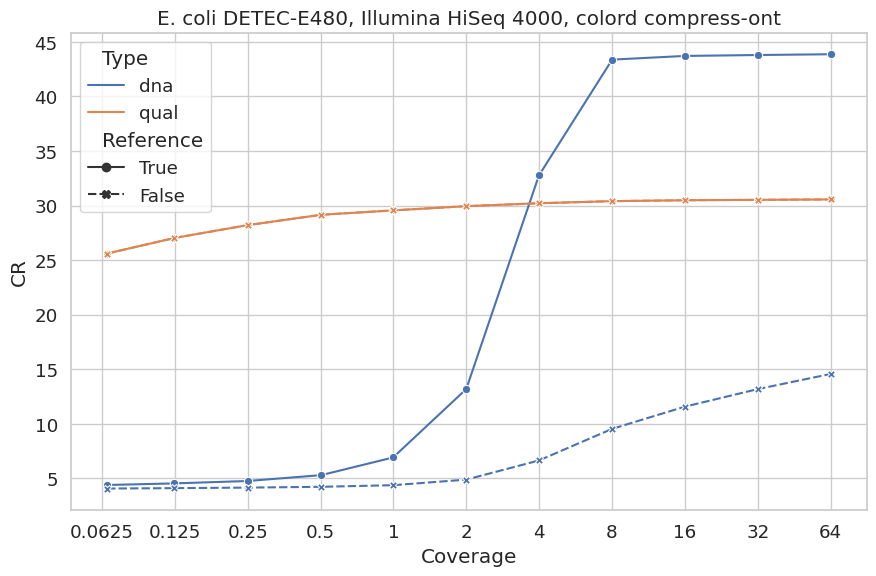

In [12]:
sns.lineplot(data=df_long, x='Coverage', y='CR', hue='Type', style='Reference', markers=True, style_order=[True, False])
plt.xscale('log')

plt.title(data_title)
plt.xticks(cov_to_check, [str(c).removesuffix('.0') for c in cov_to_check]);
plt.tight_layout();
plt.savefig(chart_prefix + 'cr-vs-ref.pdf');

## Calculate Total Time

In [13]:
# calculating stats for every file
def calculate_time_stats(filenames, logs):   
    stats = defaultdict(list)
    for inp, logfile, coverage in zip(filenames, logs, coverages):
        log, log_tab = parse_log_file(logfile)
        
        stats['Filename'].append(os.path.basename(inp))
        stats['Coverage'].append(coverage)
        stats['Total time, s'].append(float(log['Total time'][:-1]))
        
    return stats
        
time_stats = calculate_time_stats(filenames, logs)
time_stats_r = calculate_time_stats(filenames, logs_r)

In [14]:
df = pd.DataFrame.from_dict(time_stats).set_index('Filename')
df['Reference'] = False

df_r = pd.DataFrame.from_dict(time_stats_r).set_index('Filename')
df_r['Reference'] = True

df_time = pd.concat([df, df_r])
df_time

,Coverage,"Total time, s",Reference
Filename,,,
SRR22543904_1-subs-cov-0.0625.fastq,0.065662,0.307829,False
SRR22543904_1-subs-cov-0.125.fastq,0.124444,0.326386,False
SRR22543904_1-subs-cov-0.25.fastq,0.249867,0.359071,False
SRR22543904_1-subs-cov-0.5.fastq,0.503419,0.468290,False
SRR22543904_1-subs-cov-1.fastq,0.996849,0.760762,False
SRR22543904_1-subs-cov-2.fastq,1.998619,1.089310,False
SRR22543904_1-subs-cov-4.fastq,3.989525,2.092160,False
SRR22543904_1-subs-cov-8.fastq,8.008182,4.679390,False
SRR22543904_1-subs-cov-16.fastq,15.985157,9.722390,False


## Coverage vs Time Chart

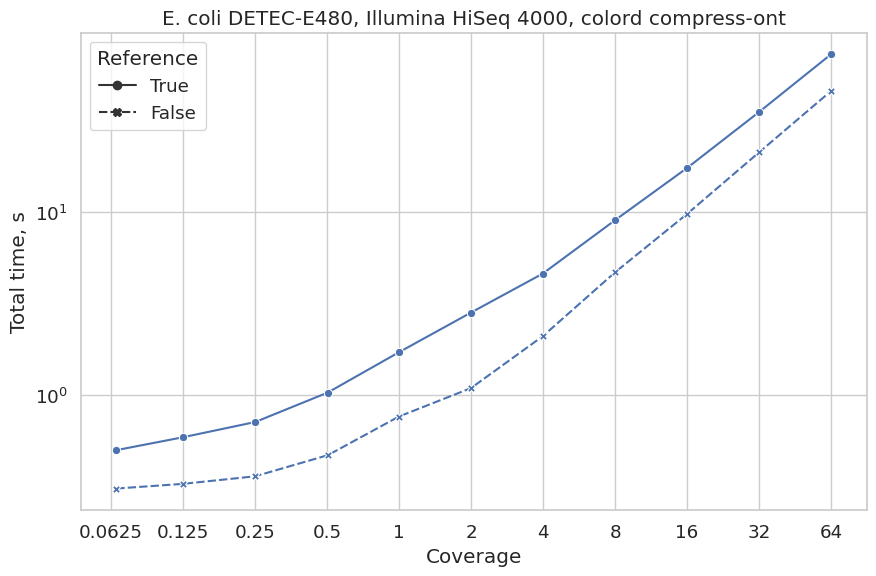

In [15]:
sns.lineplot(data=df_time, x='Coverage', y='Total time, s', style='Reference', markers=True, style_order=[True, False])
plt.xscale('log')
plt.yscale('log')

plt.title(data_title)
plt.xticks(cov_to_check, [str(c).removesuffix('.0') for c in cov_to_check]);
# plt.yticks(cov_to_check, [str(c).removesuffix('.0') for c in cov_to_check]);
plt.tight_layout();
plt.savefig(chart_prefix + 'time-vs-ref.pdf');

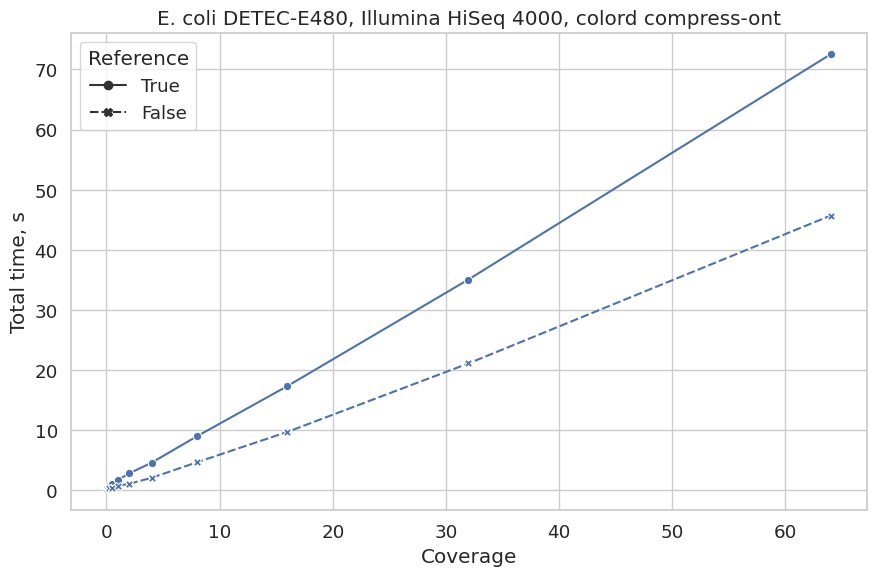

In [16]:
sns.lineplot(data=df_time, x='Coverage', y='Total time, s', style='Reference', markers=True, style_order=[True, False])

plt.title(data_title)
plt.tight_layout();
plt.savefig(chart_prefix + 'time-vs-ref-unlog.pdf');

## Calculate Threads Time

In [17]:
def collect_time_no_tab(log):
    # evene messier!
    with open(log) as f:
        return [float(line.removeprefix('Time: ').removesuffix('s\n'))
               for line in f if line.startswith("Time:")]

In [18]:
# calculating stats for every file
def calculate_threads_time_stats(filenames, logs):   
    stats = defaultdict(list)
    for inp, logfile, coverage in zip(filenames, logs, coverages):
        log, log_tab = parse_log_file(logfile)
        
        stats['Filename'].append(os.path.basename(inp))
        stats['Coverage'].append(coverage)
        
        times_no_tab = collect_time_no_tab(logfile)
        have_ref = len(times_no_tab) > 2
        
        time_io = float(log_tab['reader']) + \
                  float(log_tab['store result'])
            
        time_graph = sum(float(log_tab[col]) 
                         for col in ['similarity finder', 
                                     'mean similarity finder internal',
                                     'mean encoders',
                                     'mean encoders wait on queue']) + \
                    (times_no_tab[3] if have_ref else times_no_tab[0])
        
        time_coding = sum(float(log_tab[col]) 
                         for col in log_tab.keys() if col.startswith('entr. compr.'))
                     
        
        stats['Time - IO'].append(time_io)
        stats['Time - Sim.Graph'].append(time_graph)   
        stats['Time - RangeCoding'].append(time_coding)
        
    return stats
        
time_stats_th = calculate_threads_time_stats(filenames, logs)
time_stats_th_r = calculate_threads_time_stats(filenames, logs_r)

In [19]:
df = pd.DataFrame.from_dict(time_stats_th).set_index('Filename')
df['Reference'] = False

df_r = pd.DataFrame.from_dict(time_stats_th_r).set_index('Filename')
df_r['Reference'] = True

df_th_t = pd.concat([df, df_r])
df_th_t

,Coverage,Time - IO,Time - Sim.Graph,Time - RangeCoding,Reference
Filename,,,,,
SRR22543904_1-subs-cov-0.0625.fastq,0.065662,0.015036,0.021814,0.086969,False
SRR22543904_1-subs-cov-0.125.fastq,0.124444,0.018602,0.028115,0.113855,False
SRR22543904_1-subs-cov-0.25.fastq,0.249867,0.026420,0.041617,0.159629,False
SRR22543904_1-subs-cov-0.5.fastq,0.503419,0.038348,0.070093,0.196192,False
SRR22543904_1-subs-cov-1.fastq,0.996849,0.079491,0.142433,0.412433,False
SRR22543904_1-subs-cov-2.fastq,1.998619,0.129772,0.335472,0.563143,False
SRR22543904_1-subs-cov-4.fastq,3.989525,0.256535,1.168624,1.044287,False
SRR22543904_1-subs-cov-8.fastq,8.008182,0.525683,3.685837,2.265571,False
SRR22543904_1-subs-cov-16.fastq,15.985157,1.209693,9.538247,4.711138,False


## Coverage vs Thread Time

In [20]:
df_long = pd.melt(df_th_t, id_vars=['Coverage', 'Reference'], 
                  value_vars=['Time - IO', 'Time - Sim.Graph', 'Time - RangeCoding'], 
                  var_name='Thread', value_name='Time, s')

df_long['Thread'] = [s[7:] for s in df_long['Thread']]
df_long

,Coverage,Reference,Thread,"Time, s"
0,0.065662,False,IO,0.015036
1,0.124444,False,IO,0.018602
2,0.249867,False,IO,0.026420
3,0.503419,False,IO,0.038348
4,0.996849,False,IO,0.079491
...,...,...,...,...
61,3.989525,True,RangeCoding,0.803462
62,8.008182,True,RangeCoding,1.746512
63,15.985157,True,RangeCoding,3.760012
64,31.987208,True,RangeCoding,8.039510


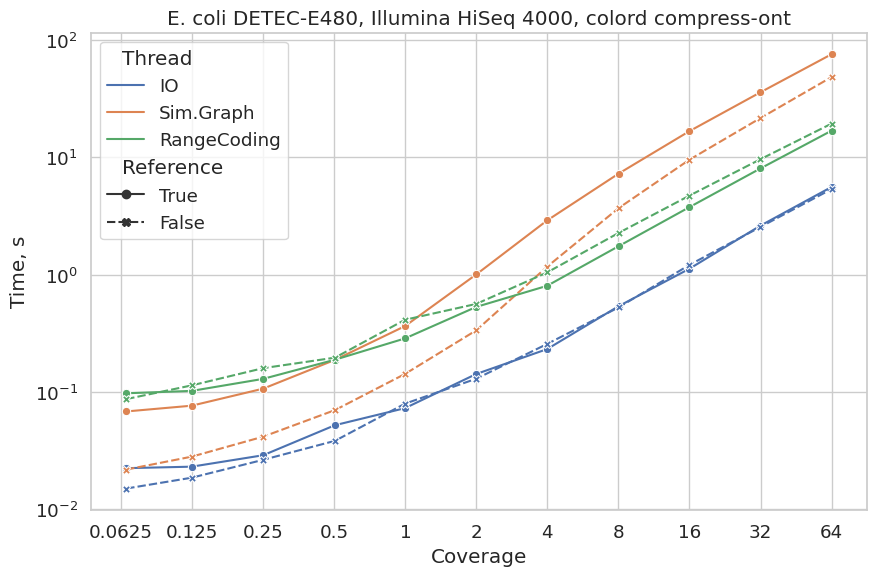

In [21]:
sns.lineplot(data=df_long, x='Coverage', y='Time, s', hue='Thread', style='Reference', markers=True, style_order=[True, False])
plt.xscale('log')
plt.yscale('log')

plt.title(data_title)
plt.xticks(cov_to_check, [str(c).removesuffix('.0') for c in cov_to_check]);
plt.tight_layout();
plt.savefig(chart_prefix + 'thread-time-vs-ref.pdf');
# plt.savefig(chart_prefix + 'thread-time-vs-ref.png', dpi=300);


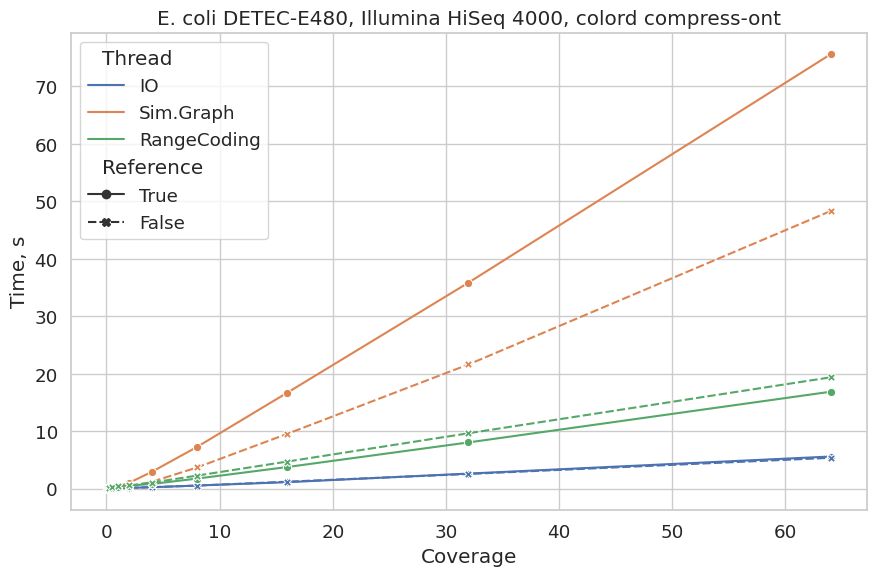

In [22]:
sns.lineplot(data=df_long, x='Coverage', y='Time, s', hue='Thread', style='Reference', markers=True, style_order=[True, False])
# plt.xscale('log')
# plt.yscale('log')

plt.title(data_title)
# plt.xticks(cov_to_check, [str(c).removesuffix('.0') for c in cov_to_check]);
plt.tight_layout();
plt.savefig(chart_prefix + 'thread-time-vs-ref-unlog.pdf');
# plt.savefig(chart_prefix + 'thread-time-vs-ref.png', dpi=300);
